<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-393 Máquinas de Aprendizaje II-2018 </h1>

<H3 align='center'> Tarea 1  </H3>
<hr style="height:2px;border:none"/>

<h4 align='center'> Integrantes: Pablo Aguirre, Rol: 201473555-3; Jorge Aliste, Rol: 201473538-3 </h4>

## Pregunta 3

En este problema se trabajará con un dataset de twits etiquetados según la emocion que desprenden. Se quiere entrenar un modelo capaz de predecir la emoción de un mensaje en base a su contenido.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re, time, string
from nltk import WordNetLemmatizer, word_tokenize

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import Perceptron,LogisticRegression
from sklearn.multiclass import OneVsRestClassifier, OutputCodeClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
#from sklearn.multiclass import OutputCodeClassifier
from sklearn.decomposition import TruncatedSVD

#import multiprocessing
#from sklearn import utils
from sklearn.metrics import confusion_matrix

#pd.options.mode.chained_assignment = None  # default='warn'

> a) Construya un dataframe con los datos a analizar. Determine cuántas clases existen, cuántos registros por clase y describa el dataset.

In [2]:
df = pd.read_csv('text_emotion.csv')

df.head()

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...


El dataset se compone de 4 atributos, los cuales son:
+ **tweet_id**: id del tweet.
+ **sentiment**: sentimiento con el que fue clasificado el tweet.
+ **author**: usuario que escribió el tweet.
+ **content**: mensaje que contiene el tweet.

In [3]:
df.shape

(40000, 4)

El dataset contiene 40.000 registros, cada uno con 4 atributos.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 4 columns):
tweet_id     40000 non-null int64
sentiment    40000 non-null object
author       40000 non-null object
content      40000 non-null object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


Del resumen del dataset, se puede observar que ningún atributo cuenta con registros nulos.

In [5]:
df['sentiment'].value_counts()

neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64

Se tienen 13 clases:
+ **neutral**: 8638 registros.
+ **worry**: 8459 registros.
+ **happiness**: 5209 registros.
+ **sadness**: 5165 registros.
+ **love**: 3842 registros.
+ **surprise**: 2187 registros.
+ **fun**: 1776 registros.
+ **relief**: 1526 registros.
+ **hate**: 1323 registros.
+ **empty**: 827 registros.
+ **enthusiasm**: 759 registros.
+ **boredom**: 179 registros.
+ **anger**: 110 registros.


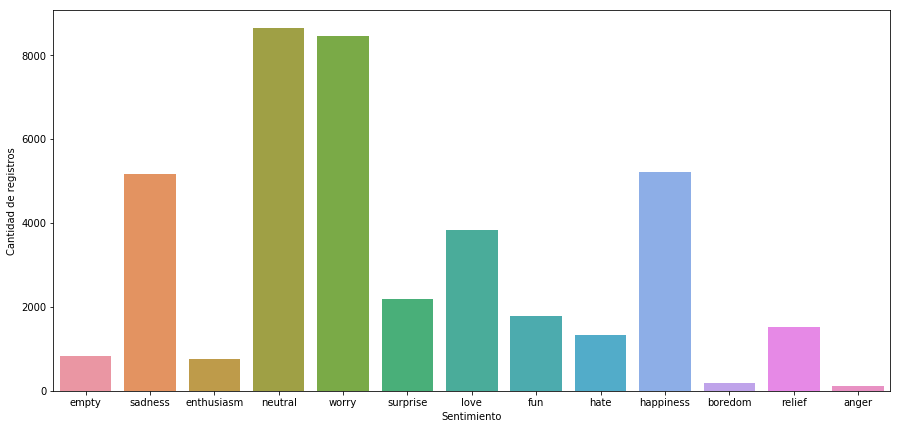

In [6]:
plt.figure(figsize=(15,7))
sns.countplot(x= "sentiment",data=df)
plt.xlabel("Sentimiento")
plt.ylabel("Cantidad de registros")
plt.show()

Se puede observar que las clases no estan distribuidas equitativamente por lo que el modelo podría preferir aquellas que son más frecuentes e ignorar las otras.

> b) Construya un conjunto de entrenamiento y otro de pruebas, a través de una máscara aleatoria, para verificar los resultados de los algoritmos. Genere un conjunto de validación si estima conveniente.

In [7]:
np.random.seed(70)
msk = np.random.rand(len(df)) < 0.8
df_train_val = df[msk].copy()
df_test = df[~msk].copy()

msk2 = np.random.rand(len(df_train_val)) < 0.8
df_train = df_train_val[msk2].copy()
df_val = df_train_val[~msk2].copy()

> c) Construya las representaciones de los datos con los que trabajará, ya sea para las entradas de los modelos como para las salidas. Recuerde que tendrá que codificar las distintas clases como valores numéricos enteros. 

El primer paso será codificar las clases a valores númericos para que puedan ser procesadas por los casificadores.

In [8]:
def codificarClases(clase):
    categorias = {
        "neutral": 0,
        "worry": 1,
        "happiness": 2,
        "sadness": 3,
        "love": 4,
        "surprise": 5,
        "fun": 6,
        "relief": 7,
        "hate": 8,
        "empty": 9,
        "enthusiasm": 10,
        "boredom": 11,
        "anger": 12   
    }
    return categorias[clase]

df_train['sentiment'] = df_train['sentiment'].apply(codificarClases)
df_val['sentiment'] = df_val['sentiment'].apply(codificarClases)
df_test['sentiment'] = df_test['sentiment'].apply(codificarClases)

In [9]:
df_train["sentiment"].value_counts()

0     5578
1     5361
3     3328
2     3311
4     2496
5     1426
6     1119
7      972
8      867
9      486
10     483
11     104
12      78
Name: sentiment, dtype: int64

Luego, se pre-procesarán las entradas de los modelos usando Lematización debido a que preserva el contexto de las palabras.

In [10]:
def word_extractor(text):
    wordlemmatizer = WordNetLemmatizer()
    text = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])", " ", text)
    text = text.replace("http", " ")
    words = ""
    wordtokens = [ wordlemmatizer.lemmatize(word.lower())for word in word_tokenize(text) ]
    
    for word in wordtokens:
        if len(word) > 3:
            words+=" "+word
    return words

Se crea un nuevo atributo "content_clean" en los conjuntos de entrenamiento y prueba. Este atributo contiene el mensaje pre-procesado usando la funcion word_extractor

In [11]:
df_train['content_clean'] = df_train['content'].apply(word_extractor)
df_val['content_clean'] = df_val['content'].apply(word_extractor)
df_test['content_clean'] = df_test['content'].apply(word_extractor)

In [12]:
df_train.head()

,tweet_id,sentiment,author,content,content_clean
2,1956967696,3,coolfunky,Funeral ceremony...gloomy friday...,funeral ceremony gloomy friday
4,1956968416,0,xkilljoyx,@dannycastillo We want to trade with someone w...,want trade with someone houston ticket will
5,1956968477,1,xxxPEACHESxxx,Re-pinging @ghostridah14: why didn't you go to...,pinging didn prom didn like friend
7,1956968636,1,mcsleazy,Hmmm. http://www.djhero.com/ is down,hmmm djhero down
10,1956969456,0,feinyheiny,cant fall asleep,cant fall asleep


Se separan ambos conjuntos en entradas y salidas.

In [13]:
X_train = df_train.content_clean
Y_train = df_train.sentiment

X_val = df_val.content_clean
Y_val = df_val.sentiment

X_test = df_test.content_clean
Y_test = df_test.sentiment

Se construyen las estructuras que serán utilizadas para el proceso de aprendizaje del modelo.

In [14]:
start = time.time()

vectorizer = CountVectorizer(stop_words='english', ngram_range=(1, 2), min_df = 2)
vectorizer.fit(np.asarray(X_train))

features_train = vectorizer.transform(X_train)
features_val = vectorizer.transform(X_val)
features_test = vectorizer.transform(X_test)

labels_train = np.asarray(Y_train)
labels_val = np.asarray(Y_val)
labels_test = np.asarray(Y_test)

print("Tiempo que tarda en ejecutarse:", round(time.time()-start, 1), "segundos")

Tiempo que tarda en ejecutarse: 1.0 segundos


In [15]:
vocab = vectorizer.get_feature_names()
dist=list(np.array(features_train.sum(axis=0)).reshape(-1,))
lista = zip(vocab, dist)
lista_ordenada = sorted(lista, key=lambda x: x[1], reverse=True)
lista_ordenada

[('just', 2086),
 ('good', 1449),
 ('like', 1260),
 ('quot', 1183),
 ('love', 1135),
 ('today', 1103),
 ('work', 1082),
 ('time', 991),
 ('going', 984),
 ('happy', 959),
 ('know', 882),
 ('really', 850),
 ('mother', 780),
 ('night', 769),
 ('want', 747),
 ('think', 699),
 ('home', 688),
 ('thanks', 675),
 ('need', 618),
 ('miss', 571),
 ('feel', 567),
 ('great', 553),
 ('morning', 552),
 ('hope', 548),
 ('twitter', 545),
 ('make', 536),
 ('haha', 524),
 ('wish', 494),
 ('week', 467),
 ('happy mother', 463),
 ('tomorrow', 454),
 ('tonight', 441),
 ('thing', 440),
 ('sorry', 439),
 ('friend', 432),
 ('look', 432),
 ('right', 426),
 ('better', 407),
 ('nice', 401),
 ('come', 400),
 ('weekend', 385),
 ('yeah', 384),
 ('sleep', 379),
 ('getting', 370),
 ('hate', 356),
 ('hour', 356),
 ('people', 341),
 ('wait', 336),
 ('twitpic', 334),
 ('didn', 328),
 ('school', 328),
 ('awesome', 322),
 ('watching', 306),
 ('dont', 303),
 ('movie', 301),
 ('little', 297),
 ('best', 286),
 ('thank', 285),


En la celda anterior se muestran las palabras del vocabulario generado junto con "algo" en la que aparecen.

> d) Entrene y compare al menos 4 de los diferentes clasificadores vistos en clases para clasificación (por ejemplo: Navie Bayes, Multinomial Naive Bayes, LDA, QDA, Regresión logı́stica y Perceptrón). Recuerde que algunos son extendidos por defecto a múltiples clases para detectar emociones en cada *tweet*, sin embargo, otros deben ser extentidos a través de otras técnicas, tal como *One vs One* y *One vs All/Rest*. Muestre tabla o gráfico resumen.

El primer clasificador será de Regresión Logística con parámetros `multi_class = 'multinomial'` ya que es un problema con multiples clases.

In [16]:
modelLogistic = LogisticRegression(multi_class='ovr' or 'multinomial', penalty = 'l2', max_iter=200)
modelLogistic.fit(features_train, labels_train)

print("Accuracy sobre entrenamiento: ", round(modelLogistic.score(features_train, labels_train), 2))
print("Accuracy sobre validación: ", round(modelLogistic.score(features_val,labels_val), 2))

Accuracy sobre entrenamiento:  0.67
Accuracy sobre validación:  0.32


El siguiente clasificador a utilizar es el Perceptrón.

In [17]:
classifPerceptron = Perceptron(penalty='l2', n_jobs=-1, max_iter=200)
classifPerceptron.fit(features_train, labels_train)

print("Accuracy sobre entrenamiento: ", round(classifPerceptron.score(features_train, labels_train), 2))
print("Accuracy sobre validación: ", round(classifPerceptron.score(features_val,labels_val), 2))

Accuracy sobre entrenamiento:  0.33
Accuracy sobre validación:  0.23


Luego, se implementará clasificador Multinomial Naive Bayes

In [18]:
modelMNB = MultinomialNB()
modelMNB.fit(features_train, labels_train)

print("Accuracy sobre entrenamiento: ", round(modelMNB.score(features_train, labels_train), 2))
print("Accuracy sobre validación: ", round(modelMNB.score(features_val,labels_val), 2))

Accuracy sobre entrenamiento:  0.55
Accuracy sobre validación:  0.32


Finalmente, se implementará un clasificador Bernoulli Naive Bayes usando la técnica One vs Rest

In [19]:
modelBNB = OneVsRestClassifier(BernoulliNB())
modelBNB.fit(features_train, labels_train)

print("Accuracy sobre entrenamiento: ", round(modelBNB.score(features_train, labels_train), 2))
print("Accuracy sobre validación: ", round(modelBNB.score(features_val,labels_val), 2))

Accuracy sobre entrenamiento:  0.51
Accuracy sobre validación:  0.3


> e) Utilice la técnica de ECOC (*Error-Correcting Output-Code*) para extender a multiclases algunos de los clasificadores utilizados en d). Comente lo que hace la técnica y los resultados observados.

Primero se debe reducir la dimensionalidad debido a que la técnica ECOC ocupa bastante memoria. Para esto se utiliza TruncatedSVD con parámetro n_components = 100 que representa la nueva dimension.

In [20]:
svd = TruncatedSVD(n_components=100, random_state = 42, n_iter = 10)

X_train_svd = svd.fit_transform(features_train)
X_val_svd = svd.transform(features_val)
X_test_svd = svd.transform(features_test)

In [21]:
features_train

<25609x15433 sparse matrix of type '<class 'numpy.int64'>'
	with 143738 stored elements in Compressed Sparse Row format>

In [22]:
modelLogisticECOC = OutputCodeClassifier(LogisticRegression(max_iter = 200), code_size=2, random_state=42)
modelLogisticECOC.fit(X_train_svd, labels_train)

print("Accuracy sobre entrenamiento: ", round(modelLogisticECOC.score(X_train_svd, labels_train), 2))
print("Accuracy sobre validación: ", round(modelLogisticECOC.score(X_val_svd,labels_val), 2))

Accuracy sobre entrenamiento:  0.31
Accuracy sobre validación:  0.29


> f) Evalúe la métrica de *accuracy* sobre el conjunto de pruebas del mejor clasificador encontrado.  
*Recuerde que puede acudir a otras métricas para tener otras visiones de lo que está haciendo el modelo de aprendizaje*

In [23]:
print("Accuracy sobre test RegLog: ", round(modelLogistic.score(features_test,labels_test), 2))

print("Accuracy sobre test Perceptron: ", round(classifPerceptron.score(features_test,labels_test), 2))

print("Accuracy sobre test MNB: ", round(modelMNB.score(features_test,labels_test), 2))

print("Accuracy sobre test BNB: ", round(modelBNB.score(features_test,labels_test), 2))

print("Accuracy sobre test ECOC RegLog: ", round(modelLogisticECOC.score(X_test_svd,labels_test), 2))

Accuracy sobre test RegLog:  0.33
Accuracy sobre test Perceptron:  0.23
Accuracy sobre test MNB:  0.31
Accuracy sobre test BNB:  0.31
Accuracy sobre test ECOC RegLog:  0.3


> g) Intente mejorar su resultado considerablemente a través de alguna mejora novedosa. Se espera que supere el 35% de *accuracy*.

Se usa Tf-idf para construir la matriz que se va a usar para entrenar el modelo de regresión logística.

In [24]:
start = time.time()

count_vect = CountVectorizer(stop_words='english', ngram_range=(1, 2), min_df = 1, strip_accents ='unicode')
transformer = TfidfTransformer(norm='l2',sublinear_tf=True)

# Train ##
X_train_counts = count_vect.fit_transform(X_train)
X_train_tfidf = transformer.fit_transform(X_train_counts)

#Validation
X_val_counts = count_vect.transform(X_val)
X_val_tfidf = transformer.transform(X_val_counts)

# Test
X_test_counts = count_vect.transform(X_test)
X_test_tfidf = transformer.transform(X_test_counts)

labels_train = np.asarray(Y_train)
labels_val = np.asarray(Y_val)
labels_test = np.asarray(Y_test)

print("Tiempo que tarda en ejecutarse:", round(time.time()-start, 1), "segundos")

Tiempo que tarda en ejecutarse: 0.8 segundos


In [25]:
modelLogisticTFIDF = LogisticRegression(multi_class="ovr" or "multinomial", penalty='l2', max_iter=200)
modelLogisticTFIDF.fit(X_train_tfidf, labels_train)

print("Accuracy sobre entrenamiento: ", round(modelLogisticTFIDF.score(X_train_tfidf, labels_train), 2))
print("Accuracy sobre test: ", round(modelLogisticTFIDF.score(X_test_tfidf,labels_test), 2))

Accuracy sobre entrenamiento:  0.61
Accuracy sobre test:  0.33


Se puede ver que el accuracy resultante que aplicar esta técnica no es mejor que el que se obtuvo convencionalmente.